# Pengambilan Data

In [1]:
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

In [2]:
import twitter_credentials
import perbaikan_singkatan
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

In [4]:
# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

In [5]:
# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)

In [6]:
# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
      
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                       tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

In [7]:
 class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
         
    def clean_tweet(self, tweet):
    
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w +:\/\/ \S +)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        # analysis = analysis.translate(from_lang = 'in',to='en')

        if analysis.sentiment.polarity > 0:
            return "Positif"
        elif analysis.sentiment.polarity == 0:
            return "Netral"
        else:
            return "Negatif"
        
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        
        df['id'] = np.array([tweet.id_str for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['lang'] = np.array([tweet.lang for tweet in tweets])
        df['place'] = np.array([tweet.place for tweet in tweets ])
        

        return df

In [8]:
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    keyword = ["bitcoin"]
    api = twitter_client.get_twitter_client_api()
    tweets = api.search(keyword, count=100, lang = 'en')

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

    print(df)

                                               tweets                   id  \
0   @PollsBitcoin @hodl_american @matt_odell Take ...  1236194195703877632   
1   How much junk do you have in your home or gara...  1236194191828348930   
2   @Vis_in_numeris FALSE!  Satoshi has 1,000,000 ...  1236194146685251585   
3   success of the bitcoin proves that money first...  1236194140859269120   
4   Can you trust a hardware wallet that has been ...  1236194139131252739   
5   RT @nielo_2wit: Are you interested in learning...  1236194127697637377   
6   RT @Josh_Rager: $BTC\n\nAny long trade is a sh...  1236194086723477506   
7   @EconomicPilgrim @JanGold_ To gain the skills ...  1236194074878672896   
8   RT @CloakFX_trading: Exchange Rates Daily Toda...  1236194059988774918   
9   RT @DigiFinex: This week in #crypto:\n✦ India ...  1236194024689524736   
10  Pick of the Day: New to Sports betting (sorta)...  1236194002233245696   
11  Blockchain Development Services for Finance Pr...  123619400

# Preproses

In [9]:
def remove_punct(text):

    neg_pattern = re.compile(r'\b(' + '|'.join(perbaikan_singkatan.negations_dic.keys()) + r')\b')    
    #hapus simbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub('rt @[^\s]+',' ', text)
    text = re.sub('@[^\s]+',' ',text)
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    #Replace #word with word
    neg_handled = neg_pattern.sub(lambda x: perbaikan_singkatan.negations_dic[x.group()], text)
    text = re.sub(r'#([^\s]+)', r'\1', neg_handled)
    #trim
    text = text.strip('\'"')
    text  = "".join([char for char in text if char not in string.punctuation])
    #text = re.sub('[0-9]+', '', text)

    return text

df['tweet_bersih'] = df['tweets'].apply(lambda x: remove_punct(x.lower()))

In [10]:
#--- REMOVE DUPLICATES
df = df.drop_duplicates(['tweet_bersih'])
df

,tweets,id,date,source,lang,place,sentiment,tweet_bersih
0,@PollsBitcoin @hodl_american @matt_odell Take ...,1236194195703877632,2020-03-07 07:37:18,Twitter for Android,en,None,Netral,take your pick
1,How much junk do you have in your home or gara...,1236194191828348930,2020-03-07 07:37:17,Twitter for iPhone,en,None,Positif,how much junk do you have in your home or gara...
2,"@Vis_in_numeris FALSE! Satoshi has 1,000,000 ...",1236194146685251585,2020-03-07 07:37:06,Twitter for iPhone,en,None,Negatif,false satoshi has 1000000 bitcoin
3,success of the bitcoin proves that money first...,1236194140859269120,2020-03-07 07:37:05,Twitter for iPhone,en,None,Positif,success of the bitcoin proves that money first...
4,Can you trust a hardware wallet that has been ...,1236194139131252739,2020-03-07 07:37:04,SocialOomph,en,None,Netral,belum you trust a hardware wallet that has bee...
5,RT @nielo_2wit: Are you interested in learning...,1236194127697637377,2020-03-07 07:37:02,Twitter for Android,en,None,Positif,are you interested in learning how to make mo...
6,RT @Josh_Rager: $BTC\n\nAny long trade is a sh...,1236194086723477506,2020-03-07 07:36:52,Twitter for Android,en,None,Negatif,btc any long trade is a short term trade unti...
7,@EconomicPilgrim @JanGold_ To gain the skills ...,1236194074878672896,2020-03-07 07:36:49,Twitter Web App,en,None,Positif,to gain the skills and knowledge to use bitco...
8,RT @CloakFX_trading: Exchange Rates Daily Toda...,1236194059988774918,2020-03-07 07:36:45,Twitter for Android,en,None,Netral,exchange rates daily today 06032020 usd eur j...
9,RT @DigiFinex: This week in #crypto:\n✦ India ...,1236194024689524736,2020-03-07 07:36:37,Twitter for Android,en,None,Netral,this week in crypto india legalizes cryptocur...


In [12]:
df.to_excel("Data Tanggal 7 siang (bitcoin).xlsx")
df.to_csv("Data Tanggal 7 siang (bitcoin).csv")

# Visualisasi Data

In [16]:
df = pd.read_excel('Data Tanggal 7 siang (bitcoin).xlsx',header=0,encoding = 'unicode_escape')
#df = df.drop(columns = "Unnamed: 0")
df.count

<bound method DataFrame.count of     Unnamed: 0                                             tweets  \
0            0  @PollsBitcoin @hodl_american @matt_odell Take ...   
1            1  How much junk do you have in your home or gara...   
2            2  @Vis_in_numeris FALSE!  Satoshi has 1,000,000 ...   
3            3  success of the bitcoin proves that money first...   
4            4  Can you trust a hardware wallet that has been ...   
5            5  RT @nielo_2wit: Are you interested in learning...   
6            6  RT @Josh_Rager: $BTC\n\nAny long trade is a sh...   
7            7  @EconomicPilgrim @JanGold_ To gain the skills ...   
8            8  RT @CloakFX_trading: Exchange Rates Daily Toda...   
9            9  RT @DigiFinex: This week in #crypto:\n✦ India ...   
10          10  Pick of the Day: New to Sports betting (sorta)...   
11          11  Blockchain Development Services for Finance Pr...   
12          12  @elonmusk I'm an anonymous beggar. Begging for...   
1

In [17]:
df = df.drop_duplicates(['tweet_bersih'])

In [18]:
df_positif = df[df['sentiment'] == 'Positif']
df_negatif = df[df['sentiment'] == 'Negatif']
df_netral = df[df['sentiment'] == 'Netral']
df_negatif

,Unnamed: 0,tweets,id,date,source,lang,place,sentiment,tweet_bersih
2,2,"@Vis_in_numeris FALSE! Satoshi has 1,000,000 ...",1236194146685251585,2020-03-07 07:37:06,Twitter for iPhone,en,NaN,Negatif,false satoshi has 1000000 bitcoin
6,6,RT @Josh_Rager: $BTC\n\nAny long trade is a sh...,1236194086723477506,2020-03-07 07:36:52,Twitter for Android,en,NaN,Negatif,btc any long trade is a short term trade unti...
29,30,"""Which they could've printed instead... ""\nyea...",1236193797689745408,2020-03-07 07:35:43,Twitter Web App,en,NaN,Negatif,which they couldve printed instead yeah that ...
39,43,Pump is coming for $ncash! Only 6 sats\n\n$eth...,1236193631356227584,2020-03-07 07:35:03,Twitter Web App,en,NaN,Negatif,pump is coming for ncash only 6 sats eth et ce...
73,82,RT @CryptoContagion: If you think respirator m...,1236193211976204288,2020-03-07 07:33:23,Twitter for Android,en,NaN,Negatif,if you think respirator mask shortages are ba...
74,83,RT @cptn_crypt0: Ultimate #Cryptocurrency supp...,1236193206766915584,2020-03-07 07:33:22,Twitter for Android,en,NaN,Negatif,ultimate cryptocurrency support animal dude h...
76,85,This is the IQ of the fucking DONINANT MEDIA i...,1236193190144811009,2020-03-07 07:33:18,Twitter for iPhone,en,NaN,Negatif,this is the iq of the fucking doninant media i...
85,94,"50 times a day, secret behind Verma's trademar...",1236193126936489991,2020-03-07 07:33:03,dlvr.it,en,NaN,Negatif,50 times a day secret behind vermas trademark ...


In [19]:
sentimen_count = df['sentiment'].value_counts()
sentimen_count

Netral     42
Positif    41
Negatif     8
Name: sentiment, dtype: int64

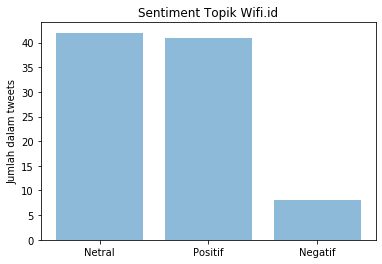

In [20]:
objects = sentimen_count.index
y_pos = np.arange(len(objects))
performance = sentimen_count
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Jumlah dalam tweets')
plt.title('Sentiment Topik Wifi.id')
 
plt.show()
plt.show()

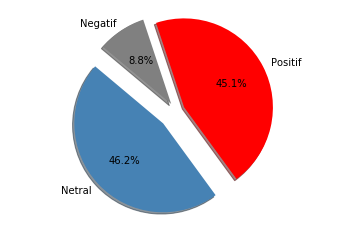

In [21]:
labels = sentimen_count.index
sizes = sentimen_count
colors = ['steelblue', 'red', 'gray']
explode = (0.2, 0.1, 0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [22]:
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [23]:
words_positif = ' '.join(df_positif['tweet_bersih'])
words_negatif = ' '.join(df_negatif['tweet_bersih'])
words_netral = ' '.join(df_netral['tweet_bersih'])

In [24]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white', 
                      height = 1000, width = 2000).generate(words_positif)

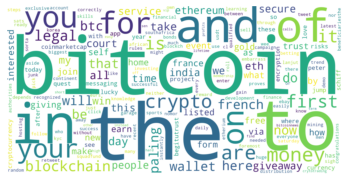

In [25]:
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [26]:
# Save the image
wordcloud.to_file("wordcloud_positif.png")

In [27]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white', 
                      height = 1000, width = 2000).generate(words_negatif)

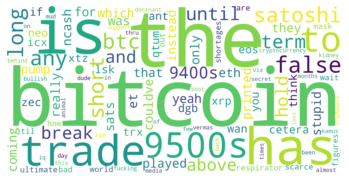

In [28]:
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [29]:
# Save the image
wordcloud.to_file("wordcloud_negatif1.png")

In [30]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white', 
                      height = 1000, width = 2000).generate(words_netral)

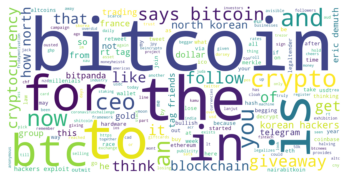

In [31]:
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [32]:
# Save the image
wordcloud.to_file("wordcloud_netral.png")